# The K-Means clustering on News (Text categorization)


This notebook tries to categorize news articles (documents) to their relevant clusters by using k-means clustering. In a way this is somewhat a hard task, because news articles can not be categorized easily as there are so many topics which all overlap and a single news article can contain many different themes. Still it can be very useful if you can categorize news articles with an acceptable quality without needing to do the manual labour. And having the option to choose the number of clusters is also useful when wanting to specify the magnitude of the categorization.

K-means clustering is an unsupervised learning algorithm. It starts by initializing a cluster position(s) randomly. #1 Then it computes a new centroid position for that spesific cluster based on the arithmetic mean of the current position (by taking the average of the vector distances in that clusters). #2 And after updating the centroid positions we reassign the vectors to the closest centroids by the shortest euclidean distance. We repeat the processes #1 and #2 as many times as necessary until it's at least a decent approximation of the converging means. Here we are going to use the NLTK implementation of the K-means. And the similarity/distance is measured using cosine similarity.

# Dataset

I am doing clustering of news articles (documents) so a good datasets from the NLTK for this is the Reuters, which is English speaking media. The dividing of the dataset happens later in the notebook. There I will divide the data into two datasets: the training set and the final test set (which the final evaluation is done on). This is because we are doing k means clustering so we don't necessarily need to use validation set.

In [1]:
# Install and import NLTK -- remove if you do not need it
!pip install nltk
import nltk
from nltk import word_tokenize

# Then download the corpora needed for ANY of the project topics:
# Feel free to remove the parts that you do not need.
nltk.download(['reuters', 'stopwords'])

from nltk.corpus import reuters, abc, stopwords
print("Ready to do something!")

Ready to do something!


[nltk_data] Downloading package reuters to /home/jovyan/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Preprocessing
Next I'm creating the list of articles with lowercase words and all the stopwords removed.

In [2]:
stop_words = set(stopwords.words('english'))
articles_reuters = [([word.lower() for word in reuters.words(fileid) if word.lower() not in stop_words], fileid) for fileid in reuters.fileids()]
# print third article as a test, you can see it's tokenized nicely
#articles_reuters[3]
print(len(articles_reuters))
print("All done")

10788
All done


# Vectorization of the documents

Now there are many ways we could vectorize the text in the preprocessed articles. Here we are going to create a two sets of vectors using different methods: tfidf and doc2vec. Because later we comper which method works better for clustering. Tfidf is supposed to be more of a keyword based vectorization where as doc2vec tries to be more of a context and semantics based vectorization. Doc2vec is a more sophisticated version of the 'context based focus word with features' model we did in the course. The tfidf we are going get from sklearn.TfidfVectorizer. You could also use the countvectorizer, but TfidfVectorizer is better for this. For the doc2vec we are going to use gensim.models.doc2vec. Both of these use the cosine similarity for the distance/similarity measure. The reason why we are not going to implement these two from scratch is that these are somewhat sophisticated to build yourself.

In [3]:
# the necessarily imports
!pip install gensim
!pip install scikit-learn
!pip install matplotlib
%matplotlib inline
from gensim.models import doc2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

## Generating the doc2vec Vectors

This code should work with these parameters, but if you get rate limited then try to decrease the parameters (not recommended). The wait time is about 2 minutes. Here we only vectorize the article texts and do not vectorize any of the categories data as it won't be used for training.

In [4]:
print("This will approximately take 2 minutes...")
tagged_documents = [doc2vec.TaggedDocument(document[0],[i]) for i, document in enumerate(articles_reuters)]
embeddings = doc2vec.Doc2Vec(vector_size=300, min_count=2, epochs=25, window=20)
embeddings.build_vocab(tagged_documents)
embeddings.train(tagged_documents, total_examples=embeddings.corpus_count, epochs=embeddings.epochs)
gensim_vectorized = [embeddings.dv[doc.tags[0]] for doc in tagged_documents]
print(len(gensim_vectorized))
print("All done")
# test print, do not print the whole dict
# print(gensim_vectorized[3])

This will approximately take 2 minutes...
10788
All done


## Generating the TFIDF Vectors

The wait is about 5 minutes. Sometimes the kernal can die while doing this. If that happens too often you can try to lower the components (but this might break something else). Also here we only vectorize the article texts and do not vectorize any of the categories data as it won't be used for training neither.

In [5]:
print("This will approximately takes 5 minutes...")
joined_documents = [" ".join(words[0]) for words in articles_reuters]
tfv = TfidfVectorizer(lowercase=True, sublinear_tf=True, use_idf=True, norm="l2")
dense_matrix = tfv.fit_transform(joined_documents)
vector_size = dense_matrix.shape
print(f"original vector dimension: {vector_size}")
svd = TruncatedSVD(n_components=5000)
truncated_matrix = svd.fit_transform(dense_matrix)
truncated_vector_size = truncated_matrix.shape
print(f"truncated vector dimension: {truncated_vector_size}")
tfidf_vectorized = [truncated_matrix[doc_id] for doc_id in range(truncated_vector_size[0])]
print("All done")

This will approximately takes 5 minutes...
original vector dimension: (10788, 30778)
truncated vector dimension: (10788, 5000)
All done


## Features explained

Quick explanation of the features in doc2vec and TFIDF:
- doc2vec: captures some semantics using positional context, in this case the context window (neighboring words) is set to 20
- doc2vec: precisely the individual dimensions can not be considered as easily interpretable features, as they are learned and not hard coded
- tfidf: the features are the unique words extracted from all of the articles
- tfidf: similarly the features are automatically extracted 

As these methods are more complex it can easily seem that the features are hidden or non-existent, which is not true (and good to keep in mind)

# Divide Dataset

Now let's divide the data as explained before. In total there are 10788 articles in the reuters dataset. The file IDs in the NLTK reuters dataset has already been labeled either as "training/xxxxx" or "test/xxxxx". Let's check how many training and test file ids there are. We do not need a validation dataset for clustering as stated before.

In [6]:
file_ids = reuters.fileids()
training_ids = [fileid for fileid in file_ids if fileid.startswith('training')]
test_ids = [fileid for fileid in file_ids if fileid.startswith('test')]
print(f"There are {len(training_ids)} training file ids")
print(f"There are {len(test_ids)} test file ids")

There are 7769 training file ids
There are 3019 test file ids


So this means the ratio is around 72% training data and 28% test data. Obviously we can change this partitioning ratio to a different one as the file id names do not matter in this case. But I think the ratio is quite good so we will use this ratio for the data division.

In [7]:
# let's use the number from before to divide our vectorized data
doc2vec_vectorized_training = gensim_vectorized[:7769]
doc2vec_vectorized_evaluation = gensim_vectorized[7769:]

tfidf_vectorized_training = tfidf_vectorized[:7769]
tfidf_vectorized_evaluation = tfidf_vectorized[7769:]

original_text_documents_training = articles_reuters[:7769]
original_text_documents_evaluation = articles_reuters[7769:]
print("all done")

all done


# Defining functions for the K-means clustering

For a comparison we can now cluster our vectorized documents using the prebuild K-means algorithm from NLTK. With gensim_vectorized we cluster 10788 300-dimensional vectors and with tfidf_vectorized we cluster 10788 5000-dimensional vectors.

In [8]:
def clustering(vectors, n_clusters, repeats):
    from nltk.cluster import KMeansClusterer, euclidean_distance
    # clustering 5 times with random seeds  
    # remember to spesify the right distance measure (ours is euclidean everytime)
    # you can change the amount of clusters if wanted, I found 4 to be pretty good and not taking too long
    clusterer = KMeansClusterer(n_clusters, euclidean_distance, repeats=repeats)
    # you can set trace=True if you want (10 trials and many iterations is enough)
    clusters = clusterer.cluster(vectors, assign_clusters=True, trace=True)
    return clusters, clusterer

Dimensionality reduction: now the results are very multi dimensional, but we can use the PCA (Principal component analysis) to reduce the dimensions to only two-dimensions and still retain important information. Another better alternative might have been t-SNE as the relationships are probably not very linear, but PCA seemed to plot better so I went with it. You can read more about these from here (math etc): 

https://www.kaggle.com/code/agsam23/pca-vs-t-sne

https://pca4ds.github.io/pca-and-clustering.html

In [9]:
# print('As:', clusters)
# print('Means:', clusterer.means())

In [10]:
#Function to use PCA to reduce dimensions to 2 and PLOT IT!
def use_pca(vectors, clusters):
    import matplotlib.pyplot
    from sklearn.decomposition import PCA
    
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)
    matplotlib.pyplot.figure(figsize=(8, 6))
    for cluster_label in set(clusters):
        label_indices = [i for i, label in enumerate(clusters) if label == cluster_label]
        # select points in current cluster
        cluster_points = reduced_vectors[label_indices]
        # plot the points in current cluster
        matplotlib.pyplot.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_label}")
    matplotlib.pyplot.title('Dimensionality reduction of clustered K-means')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.show()

Next let's create four lists that contain the corresponding cluster articles. Meaning that cero contains the articles for cluster 0 and so on. We can use these four lists to inspect the results of the first four clusters by printing some of the articles in them. And also printing the real annotated categories of them.

In [16]:
def result_clusters (docums, clusters):
    print(f"will be zipped: {len(docums)}, {len(clusters)}")
    results = list(zip(docums, clusters))
    cero, uno, dos, tres = [], [], [], []
    
    for r in range(len(docums)):
        text = results[r][0][0]
        original_id = results[r][0][1]
        categories = reuters.categories(original_id)
        cluster_num = results[r][1]
        if cluster_num  == 0:
            cero.append((text, original_id, categories))
        elif cluster_num == 1:
            uno.append((text, original_id, categories))
        elif cluster_num == 2:
            dos.append((text, original_id, categories))
        elif cluster_num == 3:
            tres.append((text, original_id, categories))

    print("CLUSTER NUMBER #0 EXAMPLES STARTS:")
    print("{")
    for i in cero[0:5]:
        print(" ".join(i[0])[0:250])
        print(f"THE ORIGINAL FILE ID{i[1]}")
        print(f"THE ANNOTATED CATEGORIES {i[2]}")
        print()
    print("} CLUSTER NUMBER #0 EXAMPLES ENDS.")
    print()
    print("CLUSTER NUMBER #1 EXAMPLES STARTS:")
    print("{")
    for i in uno[0:5]:
        print(" ".join(i[0])[0:250])
        print(f"THE ORIGINAL FILE ID{i[1]}")
        print(f"THE ANNOTATED CATEGORIES {i[2]}")
        print()
    print("} CLUSTER NUMBER #1 EXAMPLES ENDS.")
    print()
    print("CLUSTER NUMBER #2 EXAMPLES STARTS:")
    print("{")
    for i in dos[0:5]:
        print(" ".join(i[0])[0:250])
        print(f"THE ORIGINAL FILE ID{i[1]}")
        print(f"THE ANNOTATED CATEGORIES {i[2]}")
        print()
    print("} CLUSTER NUMBER #2 EXAMPLES ENDS.")
    print()
    print("CLUSTER NUMBER #3 EXAMPLES STARTS:")
    print("{")
    for i in tres[0:5]:
        print(" ".join(i[0])[0:250])
        print(f"THE ORIGINAL FILE ID{i[1]}")
        print(f"THE ANNOTATED CATEGORIES {i[2]}")
        print()
    print("} CLUSTER NUMBER #3 EXAMPLES ENDS.")

# Now first the 10788 300-dimensional vectors meaning vec2doc

Now let's use the training dataset for training the clusters and plotting them for easy interpretation. 
And also printing the examples articles for the four first clusters. This takes some time (the clustering part), about 5 minutes. We will use the big cluster amount of 15, because in the annotated labels there are 90 different categories for the Reuters articles. This means that if we want evaluate the performance of our clusters by comparing to the real categories, we need decently big number of clusters so that the clusters can somewhat resemble the real categories. It's good to have as many trial repeats as possible since bigger number of repeats is more likely to lead for the cluster means to converge which gives better results, but the problem is that repeats increase the computing size significantly (at least with this cluster size). So add as many repeats as you're willing to wait. Here we have five and it takes about 5 minutes.

This will approximately take 5 minutes...
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 1
iteration
k-means trial 2
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 3
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iter

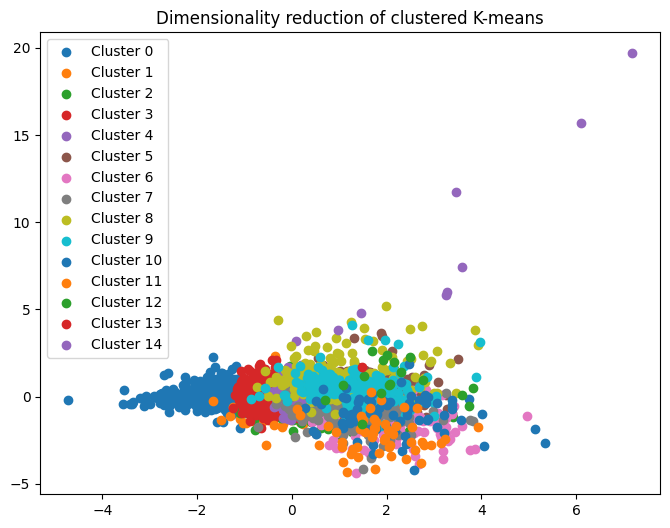

will be zipped: 7769, 7769
CLUSTER NUMBER #0 EXAMPLES STARTS:
{
thai trade deficit widens first quarter thailand ' trade deficit widened 4 . 5 billion baht first quarter 1987 2 . 1 billion year ago , business economics department said . said janunary / march imports rose 65 . 1 billion baht 58 . 7 billion . thail
THE ORIGINAL FILE IDtest/14832
THE ANNOTATED CATEGORIES ['corn', 'grain', 'rice', 'rubber', 'sugar', 'tin', 'trade']

north yemen calls sugar buying tender - trade north yemen called buying tender saturday purchase 30 , 000 tonnes white sugar arrival june , traders said .
THE ORIGINAL FILE IDtest/14886
THE ANNOTATED CATEGORIES ['sugar']

indonesian inflation rate 8 . 8 pct 1986 / 87 inflation 8 . 8 pct indonesia fiscal 1986 / 87 march 31 , compared 5 . 66 pct previous year , information minister harmoko said cabinet session discuss economic situation .
THE ORIGINAL FILE IDtest/14918
THE ANNOTATED CATEGORIES ['cpi']

pall corp & lt ; pll > sets quarterly dividend qtly div 8 - 1

In [14]:
print("This will approximately take 5 minutes...")
# use the training dataset for clusters and plot them (15 klusters and 5 repeats)
clusters_doc2vec, clusterer_doc2vec = clustering(doc2vec_vectorized_training, 15, 5)
use_pca(doc2vec_vectorized_training, clusters_doc2vec)
result_clusters(original_text_documents_training, clusters_doc2vec)

# The Second clustering with 10788 5000-dimensional vectors (TFIDF_vectorized)

Now let's do the same clustering as above but with with TFIDF vectors. This will approximately take 5 minutes with also 5 repeats and 15 clusters. Lower repeats if kernel timeouts (worse results).

This will approximately take 3 minutes...
k-means trial 0
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 1
iteration
k-means trial 2
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 3
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
k-means trial 4
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteration
iteratio

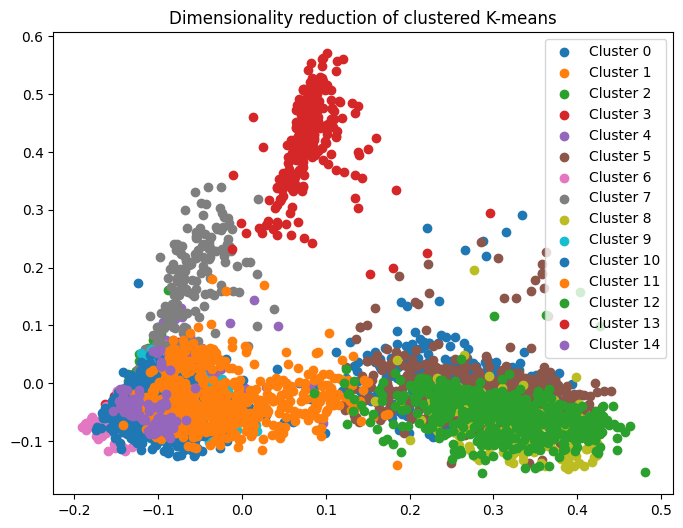

will be zipped: 7769, 7769
CLUSTER NUMBER #0 EXAMPLES STARTS:
{
computer research inc & lt ; core > 2nd qtr feb 28 net shr 14 cts vs nine cts net 217 , 572 vs 153 , 454 revs 2 , 530 , 273 vs 2 , 558 , 924 1st half shr 19 cts vs 11 cts net 299 , 838 vs 174 , 739 revs 4 , 865 , 249 vs 4 , 495 , 021
THE ORIGINAL FILE IDtest/14954
THE ANNOTATED CATEGORIES ['earn']

rubbermaid inc 1st qtr shr 28 cts vs 22 cts rubbermaid inc 1st qtr shr 28 cts vs 22 cts
THE ORIGINAL FILE IDtest/14958
THE ANNOTATED CATEGORIES ['earn']

rubbermaid inc & lt ; rbd > 1st qtr net shr 28 cts vs 22 cts net 20 . 6 mln vs 16 . 1 mln sales 238 . 0 mln vs 188 . 8 mln
THE ORIGINAL FILE IDtest/14962
THE ANNOTATED CATEGORIES ['earn']

mead corp 1st qtr oper shr 1 . 09 dlrs vs 67 cts mead corp 1st qtr oper shr 1 . 09 dlrs vs 67 cts
THE ORIGINAL FILE IDtest/14965
THE ANNOTATED CATEGORIES ['earn']

cayuga savings bank & lt ; cayb > 1st qtr net shr 55 cts vs 41 cts net 494 , 000 vs 204 , 000 avg shrs 896 , 655 vs 494 , 155
THE

In [15]:
print("This will approximately take 3 minutes...")
# use tfidf training dataset
clusters_tfidf, clusterer_tfidf = clustering(tfidf_vectorized_training, 15, 5)
use_pca(tfidf_vectorized_training, clusters_tfidf)
result_clusters(original_text_documents_training, clusters_tfidf)

# Discussing results and comparisons

The clustering with doc2vec produces 15 clusters (with these settings), which seem to have their unique themes. We can confirm this by seeing that the categories between the example cluster articles are very similar (almost same between each other). This is the best indicator if the clustering has worked since the categories are not used as a part of the training itself. But to make sure that it actually works also outside of the training data, as overfitting can be real problem, we will do the final evaluation with outside data in the next section. But still here are some promising observations.
- (Obviously the order of these cluster is changing depending on the run)!
- At least one cluster is about "acq[uisition]".
- At least one cluster is about "earning [money]" meaning stocks.
- At least one cluster is about "crude [oil]".
- At least one cluster is about "trade".
- At least one cluster is about "money-tx".
- And at least one cluster is mostly about "commodities" like coffee etc.
- And there are many more to explore.
- (These themes fit since Reuters is British and is mostly known from geopolitics and economy related news) 
- (In the end it seems that the Reuters dataset is maybe not the best possible news dataset for this clustering, as it's seems to be very narrow oriented with having no news on celebrities or sports or science etc..., meaning there are not many distinct or clear themes to cluster; meaning a lot of overlap, you can see this from the plots)

tfidf which is keyword based seems to cluster better than doc2vec. This makes sense since the keywords can more easily form their own cluster compared to the meanings/contexts of doc2vec. The problem with this can be seen with the doc2vec clusters, where there is a more overlap when the news stories don't differ much in context or in semantics. Whereas keyword based tfidf seems more scattered and clusters overall a little better (even when we truncated the dimensions by alot). But the doc2vec vectors are generated much faster and they also cluster faster than the tfidf generated vectors, because those have much higher dimensions. I think this is why the kernel sometimes dies while trying cluster or generate those bigger vectors. (this can be fixed my reducing the dimension size of the tfidf vectors; like I did from 30778 -> 5000 ). Also depending on if doc2vec or tfidf is used, it seems that the cluster themes do differ ever so slightly. For example tfidf likes to focus more on numerical data (I guess this makes sense for keywords).

# Final test set & Final evaluation

Now let's do the final evaluation of these clusters that were generated differently (doc2vec & tfidf) with the final test dataset. And see if our observations hold true.

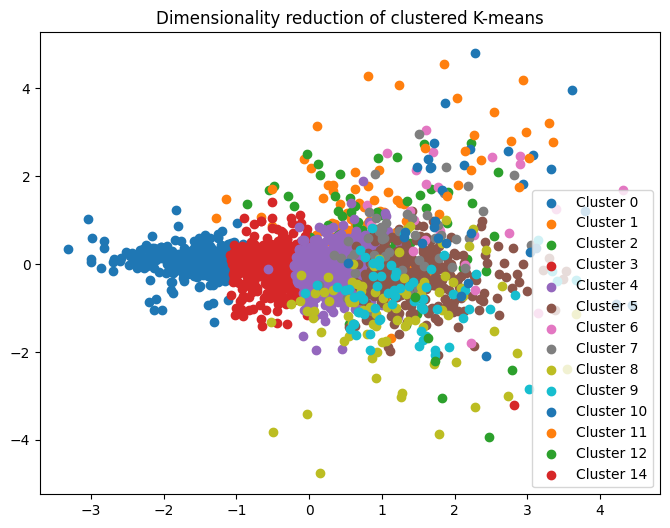

will be zipped: 3019, 3019
CLUSTER NUMBER #0 EXAMPLES STARTS:
{
endotronics sees heavy losses qtr withdrawal japan distributor endotronics sees heavy losses qtr withdrawal japan distributor
THE ORIGINAL FILE IDtraining/5326
THE ANNOTATED CATEGORIES ['earn']

diamond shamrock sets 27 pct proration factor tendered shares diamond shamrock sets 27 pct proration factor tendered shares
THE ORIGINAL FILE IDtraining/5329
THE ANNOTATED CATEGORIES ['acq']

16 - mar - 1987 16 - mar - 1987
THE ORIGINAL FILE IDtraining/5336
THE ANNOTATED CATEGORIES ['interest', 'money-fx']

ausimont compo nv & lt ; aus > raises quarterly qtly div eight cts vs five cts prior pay april 24 record april three
THE ORIGINAL FILE IDtraining/5346
THE ANNOTATED CATEGORIES ['earn']

mccormick co inc & lt ; mccrk > 1st qtr net qtr ends feb 28 shr 37 cts vs 35 cts net 4 , 346 , 000 vs 4 , 202 , 000 revs 232 , 006 , 000 vs 223 , 151 , 000
THE ORIGINAL FILE IDtraining/5355
THE ANNOTATED CATEGORIES ['earn']

} CLUSTER NUMBER #0 E

In [17]:
# use doc2vec test set for final evaluation
doc2vec_evaluated = []
for vector in doc2vec_vectorized_evaluation:
    classified = clusterer_doc2vec.classify(vector)
    doc2vec_evaluated.append(classified)
use_pca(doc2vec_vectorized_evaluation, doc2vec_evaluated)
result_clusters(original_text_documents_evaluation, doc2vec_evaluated)

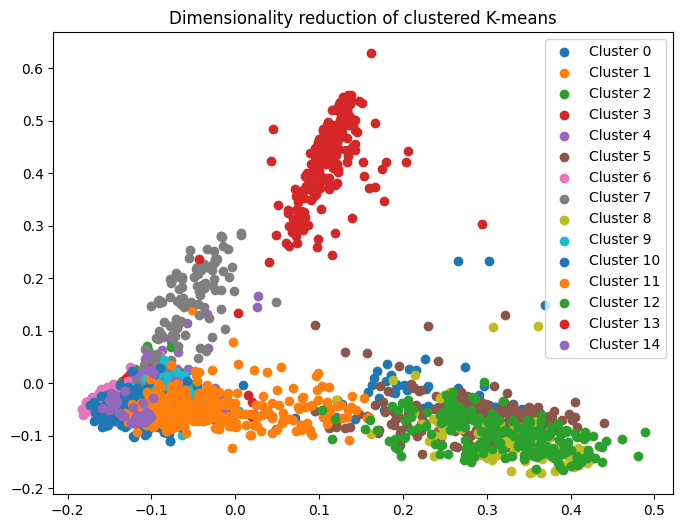

will be zipped: 3019, 3019
CLUSTER NUMBER #0 EXAMPLES STARTS:
{
commtron corp & lt ; cmr > 2nd qtr feb 28 net shr 16 cts vs 22 cts net 1 , 574 , 000 vs 1 , 725 , 000 sales 104 . 2 mln vs 116 . 0 mln avg shrs 10 . 1 mln vs eight mln 1st half shr 37 cts vs 37 cts net 3 , 675 , 000 vs 2 , 925 , 000 sales 244 . 5 mln
THE ORIGINAL FILE IDtraining/5314
THE ANNOTATED CATEGORIES ['earn']

mccormick co inc & lt ; mccrk > 1st qtr net qtr ends feb 28 shr 37 cts vs 35 cts net 4 , 346 , 000 vs 4 , 202 , 000 revs 232 , 006 , 000 vs 223 , 151 , 000
THE ORIGINAL FILE IDtraining/5355
THE ANNOTATED CATEGORIES ['earn']

hongkong bank canada 1st qtr jan 31 net net 3 . 1 mln vs given note : results comparable last year due november 1986 acquisition bank british columbia . subsidiary & lt ; hongkong shanghai banking corp >
THE ORIGINAL FILE IDtraining/5358
THE ANNOTATED CATEGORIES ['earn']

analogic corp & lt ; alog > 2nd qtr jan 31 net shr 11 cts vs 13 cts net 1 , 965 , 577 vs 2 , 474 , 357 revs 38 . 3 mln

In [18]:
# use tfidf test set for final evaluation
tfidf_evaluated = []
for vector in tfidf_vectorized_evaluation:
    classified = clusterer_tfidf.classify(vector)
    tfidf_evaluated.append(classified)
use_pca(tfidf_vectorized_evaluation, tfidf_evaluated)
result_clusters(original_text_documents_evaluation, tfidf_evaluated)

## Interpretation of the the final evaluation

From these results we can see that our observations do hold true and the model generalizes to new data. First we can compare (similarly to before) the final test data to the actual categories(labels) provided by the Reuters. Meaning we can compare the clustered articles to their actual annotated categories (which were not used in training at all) and see from that how well our clusters perform. But even more importantly we can see the fact that the categories between the articles in each cluster are almost the same every time (or very similar). This is a strong indicator that our clustering has worked quite nicely. But there seems to be some overlap between the clusters so they are not perfect (but with this dataset perfection might not even be possible).